## Common plotting pitfalls that get worse with large data

When working with large datasets, visualizations are often the only way available to understand the properties of that dataset -- there are simply too many data points to examine each one!  Thus it is very important to be aware of some common plotting problems that are minor inconveniences with small datasets but very serious problems with larger ones.

We'll cover:

1. [Overplotting](#1.-Overplotting)
2. [Oversaturation](#2.-Oversaturation)
3. [Undersampling](#3.-Undersampling)
4. [Undersaturation](#4.-Undersaturation)
5. [Underutilized range](#5.-Underutilized-range)
6. [Nonuniform colormapping](#6.-Nonuniform-colormapping)

You can [skip to the end](#Summary) if you just want to see an illustration of these problems.

This notebook requires [HoloViews](http://holoviews.org), [colorcet](https://github.com/bokeh/colorcet), and matplotlib, and optionally scikit-image, which can be installed with:


We'll first load the plotting libraries and set up some defaults:

In [1]:
# pip install holoviews
# pip install colorcet

import numpy as np
np.random.seed(42)

import holoviews as hv
hv.notebook_extension()
%opts Points [color_index=2] (cmap="bwr" edgecolors='k' s=50 alpha=1.0)
%opts Scatter3D [color_index=3 fig_size=250] (cmap='bwr' edgecolor='k' s=50 alpha=1.0)
%opts Image (cmap="gray_r") {+axiswise}

import holoviews.plotting.mpl
holoviews.plotting.mpl.MPLPlot.fig_alpha = 0
holoviews.plotting.mpl.ElementPlot.bgcolor = 'white'

C:\Anaconda3\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


### 1. Overplotting

Let's consider plotting some 2D data points that come from two separate categories, here plotted as blue and red in **A** and **B** below.  When the two categories are overlaid, the appearance of the result can be very different depending on which one is plotted first:

:Layout
   .Points.I   :Points   [x,y]   (c)
   .Points.II  :Points   [x,y]   (c)
   .Overlay.I  :Overlay
      .Points.I  :Points   [x,y]   (c)
      .Points.II :Points   [x,y]   (c)
   .Overlay.II :Overlay
      .Points.I  :Points   [x,y]   (c)
      .Points.II :Points   [x,y]   (c)
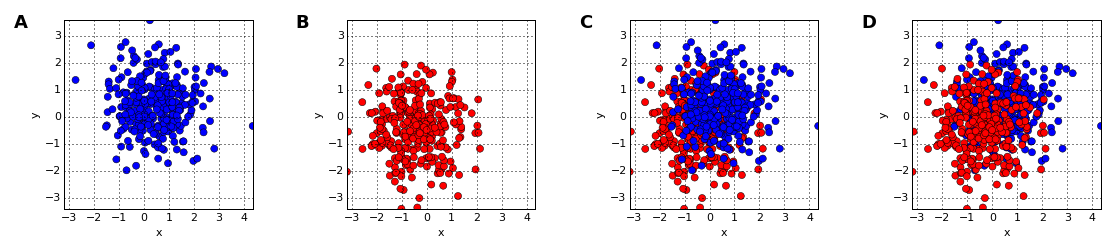

In [2]:
def blues_reds(offset=0.5,pts=300):
    blues = (np.random.normal( offset,size=pts), np.random.normal( offset,size=pts), -1*np.ones((pts)))
    reds  = (np.random.normal(-offset,size=pts), np.random.normal(-offset,size=pts),  1*np.ones((pts)))
    return hv.Points(blues, vdims=['c']), hv.Points(reds, vdims=['c'])

blues,reds = blues_reds()
blues + reds + reds*blues + blues*reds

Plots **C** and **D** shown the same distribution of points, yet they give a very different impression of which category is more common, which can lead to incorrect decisions based on this data.  Of course, both are equally common in this case.  The cause for this problem is simply occlusion:

b':Scatter3D   [x,y,level]   (c)'
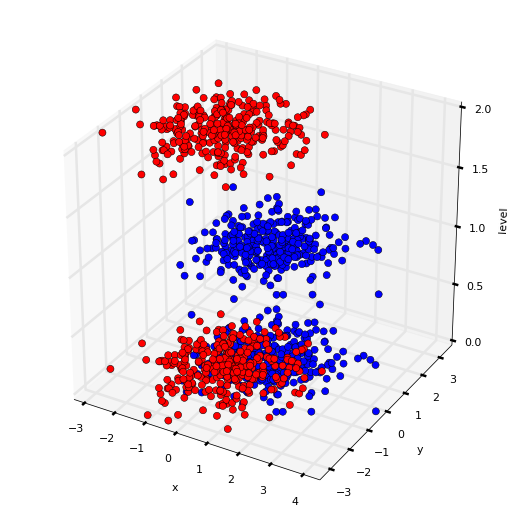

In [3]:
hmap = hv.HoloMap({0:blues,0.000001:reds,1:blues,2:reds}, key_dimensions=['level'])
hv.Scatter3D(hmap.table(), kdims=['x','y','level'], vdims=['c'])

Occlusion of data by other data is called **overplotting** or **overdrawing**, and it occurs whenever a datapoint or curve is plotted on top of another datapoint or curve, obscuring it.  It's thus a problem not just for scatterplots, as here, but for curve plots, 3D surface plots, 3D bar graphs, and any other plot type where data can be obscured.


### 2. Oversaturation

You can reduce problems with overplotting by using transparency/opacity, via the alpha parameter provided to control opacity in most plotting programs.  E.g. if alpha is 0.1, full color saturation will be achieved only when 10 points overlap, reducing the effects of plot ordering but making it harder to see individual points:

:Layout
   .Points.I   :Points   [x,y]   (c)
   .Points.II  :Points   [x,y]   (c)
   .Overlay.I  :Overlay
      .Points.I  :Points   [x,y]   (c)
      .Points.II :Points   [x,y]   (c)
   .Overlay.II :Overlay
      .Points.I  :Points   [x,y]   (c)
      .Points.II :Points   [x,y]   (c)
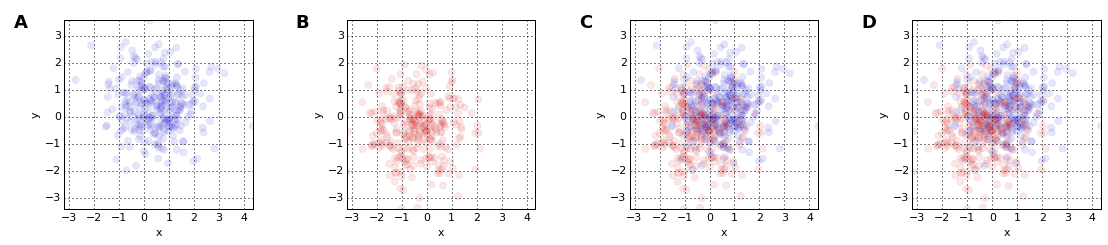

In [4]:
%%opts Points (s=50 alpha=0.1)
blues + reds + reds*blues + blues*reds

Here **C** and **D** look very similar (as they should, since the distributions are identical), but there are still a few locations with **oversaturation**, a problem that will occur when more than 10 points overlap. In this example the oversaturated points are located near the middle of the plot, but the only way to know whether they are there would be to plot both versions and compare, or to examine the pixel values to see if any have reached full saturation (a necessary but not sufficient condition for oversaturation).  Locations where saturation has been reached have problems similar to overplotting, because only the last 10 points plotted will affect the final color (for alpha of 0.1).

Worse, even if one has set the alpha value to approximately or usually avoid oversaturation, as in the plot above, the correct value depends on the dataset.  If there are more points overlapping in that particular region, a manually adjusted alpha setting that worked well for a previous dataset will systematically misrepresent the new dataset:

:Layout
   .Points.I   :Points   [x,y]   (c)
   .Points.II  :Points   [x,y]   (c)
   .Overlay.I  :Overlay
      .Points.I  :Points   [x,y]   (c)
      .Points.II :Points   [x,y]   (c)
   .Overlay.II :Overlay
      .Points.I  :Points   [x,y]   (c)
      .Points.II :Points   [x,y]   (c)
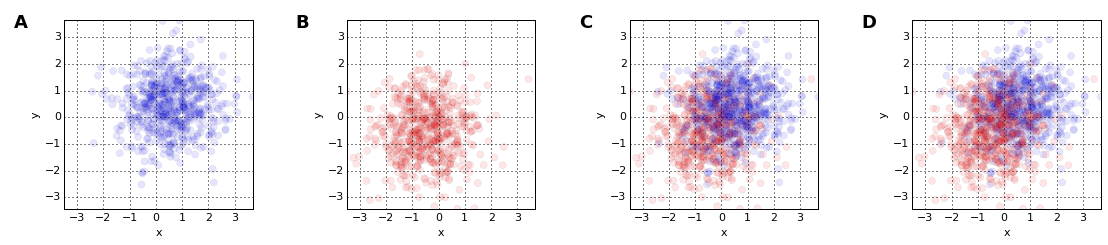

In [5]:
%%opts Points (alpha=0.1)
blues,reds = blues_reds(pts=600)
blues + reds + reds*blues + blues*reds

Here **C** and **D** again look qualitatively different, yet still represent the same distributions.  Since we're assuming that the point of the visualization is to reveal the underlying dataset, having to tune visualization parameters manually based on the properties of the dataset itself is a serious problem.

To make it even more complicated, the correct alpha also depends on the dot size, because smaller dots have less overlap for the same dataset. With smaller dots, **C** and **D** look more similar, but the color of the dots is now difficult to see in all cases because the dots are too transparent for this size:

:Layout
   .Points.I   :Points   [x,y]   (c)
   .Points.II  :Points   [x,y]   (c)
   .Overlay.I  :Overlay
      .Points.I  :Points   [x,y]   (c)
      .Points.II :Points   [x,y]   (c)
   .Overlay.II :Overlay
      .Points.I  :Points   [x,y]   (c)
      .Points.II :Points   [x,y]   (c)
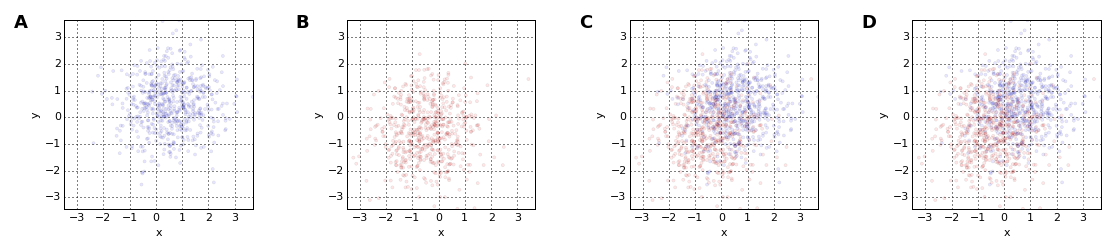

In [6]:
%%opts Points (s=10 alpha=0.1 edgecolor=None)
blues + reds + reds*blues + blues*reds

As you can see, it is very difficult to find settings for the dotsize and alpha parameters that correctly reveal the data, even for relatively small and obvious datasets like these.  With larger datasets with unknown contents, it is difficult to detect that such problems are occuring, leading to false conclusions based on inappropriately visualized data.

### 3. Undersampling

With a single category instead of the multiple categories shown above, oversaturation simply obscures spatial differences in density.  For instance, 10, 20, and 2000 single-category points overlapping will all look the same visually, for alpha=0.1.  Let's again consider an example that has a sum of two normal distributions slightly offset from one another, but no longer using color to separate them into categories:

:Layout
   .Small_dots.A_600_points   :Points   [x,y]
   .Small_dots.A_60000_points :Points   [x,y]
   .Tiny_dots.A_600_points    :Points   [x,y]
   .Tiny_dots.A_60000_points  :Points   [x,y]
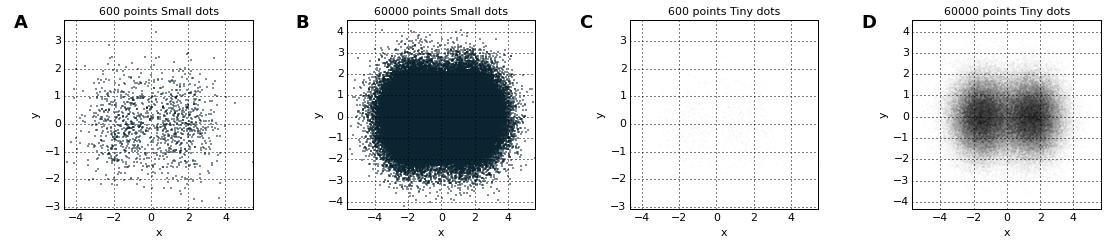

In [7]:
%%opts Points.Small_dots (s=1 alpha=1) Points.Tiny_dots (s=0.1 alpha=0.1)

def gaussians(specs=[(1.5,0,1.0),(-1.5,0,1.0)],num=100):
    """
    A concatenated list of points taken from 2D Gaussian distributions.
    Each distribution is specified as a tuple (x,y,s), where x,y is the mean
    and s is the standard deviation.  Defaults to two horizontally
    offset unit-mean Gaussians.
    """
    np.random.seed(1)
    dists = [(np.random.normal(x,s,num), np.random.normal(y,s,num)) for x,y,s in specs]
    return np.hstack([d[0] for d in dists]), np.hstack([d[1] for d in dists])
    
hv.Points(gaussians(num=600),   label="600 points",   group="Small dots") + \
hv.Points(gaussians(num=60000), label="60000 points", group="Small dots") + \
hv.Points(gaussians(num=600),   label="600 points",   group="Tiny dots")  + \
hv.Points(gaussians(num=60000), label="60000 points", group="Tiny dots")

Just as shown for the multiple-category case above, finding settings to avoid overplotting and oversaturation is difficult.  The "Small dots" setting (size 0.1, full alpha) works fairly well for a sample of 600 points **A**, but it has serious overplotting issues for larger datasets, obscuring the shape and density of the distribution **B**.  Using the "Tiny dots" setting (10 times smaller dots, alpha 0.1) works well for the larger dataset **D**, but not at all for the 600-point dataset **C**.  Clearly, not all of these settings are accurately conveying the underlying distribution, as they all appear quite different from one another. Similar problems occur for the same size of dataset, but with greater or lesser levels of overlap between points, which of course varies with every new dataset.  

In any case, as dataset size increases, at some point plotting a full scatterplot like any of these will become impractical with current plotting software.  At this point, people often simply subsample their dataset, plotting 10,000 or perhaps 100,000 randomly selected datapoints.  But as panel **A** shows, the shape of an **undersampled** distribution can be very difficult or impossible to make out, leading to incorrect conclusions about the distribution.  Such problems can occur even when taking very large numbers of samples, if examining sparsely populated regions of the space, which will approximate panel **A** for some plot settings and panel **C** for others.  The actual shape of the distribution is only visible if sufficient datapoints are available in that region *and* appropriate plot settings are used, as in **D**, but ensuring that both conditions are true is a quite difficult process of trial and error, making it very likely that important features of the dataset will be missed.

To avoid undersampling large datasets, researchers often use 2D histograms visualized as heatmaps, rather than scatterplots showing individual points.  A heatmap has a fixed-size grid regardless of the dataset size, so that they can make use of all the data.  Heatmaps effectively approximate a probability density function over the specified space, with coarser heatmaps averaging out noise or irrelevant variations to reveal an underlying distribution, and finer heatmaps able to represent more details in the distribution.

Let's look at some heatmaps with different numbers of bins for the same two-Gaussians distribution:

:Layout
   .Image.I   :Image   [x,y]   (z)
   .Image.II  :Image   [x,y]   (z)
   .Image.III :Image   [x,y]   (z)
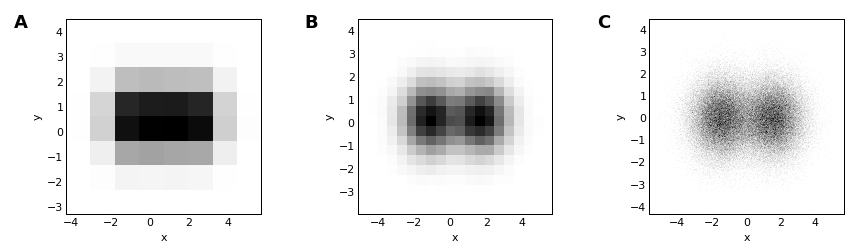

In [8]:
def heatmap(coords,bins=10,offset=0.0,transform=lambda d,m:d, label=None):
    """
    Given a set of coordinates, bins them into a 2d histogram grid
    of the specified size, and optionally transforms the counts
    and/or compresses them into a visible range starting at a 
    specified offset between 0 and 1.0.
    """
    hist,xs,ys  = np.histogram2d(coords[0], coords[1], bins=bins)
    counts      = hist[:,::-1].T
    transformed = transform(counts,counts!=0)
    span        = transformed.max()-transformed.min()
    compressed  = np.where(counts!=0,offset+(1.0-offset)*transformed/span,0)
    args        = dict(label=label) if label else {}
    return hv.Image(compressed,bounds=(xs[-1],ys[-1],xs[1],ys[1]),**args)

hv.Layout([heatmap(gaussians(num=60000),bins) for bins in [8,20,200]])

As you can see, a too-coarse binning grid **A** cannot represent this distribution faithfully, but with enough bins **C**, the heatmap will approximate a tiny-dot scatterplot like plot **D** in the previous figure.  For intermediate grid sizes **B** the heatmap can average out the effects of undersampling; **B** is actually a more faithful representation of the *distribution* than **C** is (which we know is two offset 2D Gaussians), while **C** more faithfully represents the *sampling* (i.e., the individual points drawn from this distribution).  Thus choosing a good binning grid size for a heatmap does take some expertise and knowledge of the goals of the visualization, and it's always useful to look at multiple binning-grid spacings for comparison.  Still, at least the binning parameter is something meaningful at the data level (how coarse a view of the data is desired?) rather than just a plotting detail (what size and transparency should I use for the points?) that must be determined arbitrarily.

In any case, at least in principle, the heatmap approach can entirely avoid the first three problems above: **overplotting** (since multiple data points sum arithmetically into the grid cell, without obscuring one another), **oversaturation** (because the minimum and maximum counts observed can automatically be mapped to the two ends of a visible color range), and **undersampling** (since the resulting plot size is independent of the number of data points, allowing it to use an unbounded amount of incoming data).



### 4. Undersaturation

Of course, heatmaps come with their own plotting pitfalls.  One rarely appreciated issue common to both heatmaps and alpha-based scatterplots is **undersaturation**, where large numbers of data points can be missed entirely because they are spread over many different heatmap bins or many nearly transparent scatter points.  To look at this problem, let's again consider a set of multiple 2D Gaussians, but this time with different amounts of spread (standard deviation):

:Layout
   .Points.I   :Points   [x,y]
   .Points.II  :Points   [x,y]
   .Points.III :Points   [x,y]
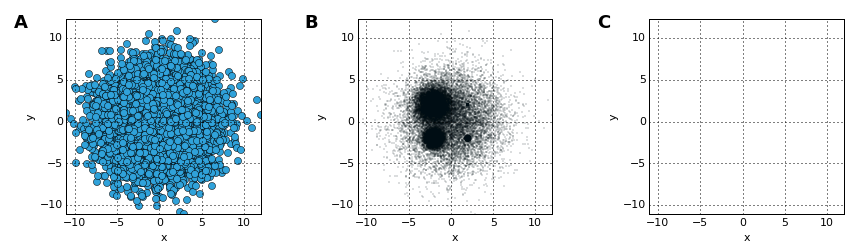

In [9]:
dist = gaussians(specs=[(2,2,0.02), (2,-2,0.1), (-2,-2,0.5), (-2,2,1.0), (0,0,3)],num=10000)
hv.Points(dist) + hv.Points(dist)(style=dict(s=0.1)) + hv.Points(dist)(style=dict(s=0.01,alpha=0.05))

Plots **A**, **B**, and **C** are all scatterplots for the same data, which is a sum of 5 Gaussian distributions at different locations and with different standard deviations:

1. Location   (2,2):  very narrow spread
2. Location  (2,-2): narrow spread
3. Location (-2,-2): medium spread
4. Location  (-2,2): large spread
5. Location   (0,0): very large spread

In plot **A**, of course, the very large spread covers up everything else, completely obscuring the structure of this dataset by overplotting.  Plots **B** and **C** reveal the structure better, but they required hand tuning and neither one is particularly satisfactory.  In **B** there are four clearly visible Gaussians, but all but the largest appear to have the same density of points per pixel, which we know is not the case from how the dataset was constructed, and the smallest is nearly invisible.  Each of the five Gaussians has the same number of data points (10000), but the second-largest looks like it has more than the others, and the narrowest one is likely to be overlooked altogether, which is thus a clear example of oversaturation obscuring important features.  Yet if we try to combat the oversaturation by using transparency in **C**, we now get a clear problem with **undersaturation** -- the "very large spread" Gaussian is now essentially invisible.  Again, there are just as many datapoints in that category, but we'd never even know they were there if only looking at **C**.

Similar problems occur for a heatmap view of the same data:

In [ ]:
hv.Layout([heatmap(dist,bins) for bins in [8,20,200]])

Here the narrow-spread distributions lead to pixels with a very high count, and if the other pixels are linearly ramped into the available color range, from zero to that high count value, then the wider-spread values are obscured (as in **B**) or entirely invisible (as in **C**). 

To avoid undersaturation, you can add an offset to ensure that low-count (but nonzero) bins are mapped into a visible color, with the remaining intensity scale used to indicate differences in counts:

:Layout
   .Image.I   :Image   [x,y]   (z)
   .Image.II  :Image   [x,y]   (z)
   .Image.III :Image   [x,y]   (z)
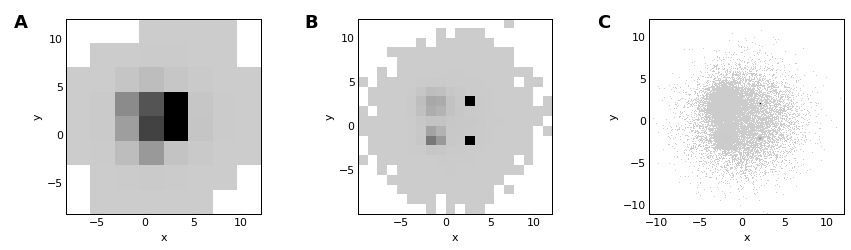

In [10]:
hv.Layout([heatmap(dist,bins,offset=0.2) for bins in [8,20,200]]).cols(4)

Such mapping entirely avoids undersaturation, since all pixels are either clearly zero (in the background color, i.e. white in this case), or a non-background color taken from the colormap.   The widest-spread Gaussian is now clearly visible in all cases.  

However, the actual structure (5 Gaussians of different spreads) is still not visible.  In **A** the problem is clearly too-coarse binning, but in **B** the binning is also somewhat too coarse for this data, since the "very narrow spread" and "narrow spread" Gaussians show up identically, each mapping entirely into a single bin (the two black pixels).  **C** shouldn't suffer from too-coarse binning, yet it still looks more like a plot of the "very large spread" distribution alone, than a plot of these five distributions of different spreads, and it is thus still highly misleading despite the correction for undersaturation.


### 5. Underutilized range

So, what is the problem in plot **C** above?  By construction, we've avoided the first four pitfalls: **overplotting**, **oversaturation**, **undersampling**, and **undersaturation**.  But the problem is now more subtle: differences in datapoint density are not visible between the five Gaussians, because all or nearly all pixels end up being mapped into either the bottom end of the visible range (light gray), or the top end (black, used only for the single pixel holding the "very narrow spread" distribution). The entire rest of the visible colors in this gray colormap are unused, conveying no information to the viewer about the rich structure that we know this distribution contains.  If the data were uniformly distributed over the range from minimum to maximum counts per pixel (0 to 10,000, in this case), then the above plot would work well, but that's not the case for this dataset or for most real-world datasets.

So, let's try transforming the data from its default linear representation (integer count values) into something that preserves relative differences in count values but maps them into visually distinct colors.  A logarithmic transformation is one common choice:

:Layout
   .Image.I   :Image   [x,y]   (z)
   .Image.II  :Image   [x,y]   (z)
   .Image.III :Image   [x,y]   (z)
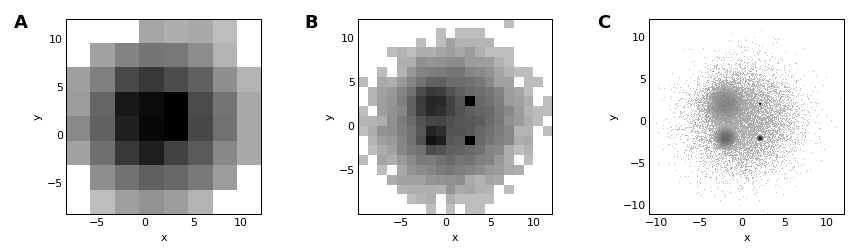

In [11]:
hv.Layout([heatmap(dist,bins,offset=0.2,transform=lambda d,m: np.where(m,np.log1p(d),0)) for bins in [8,20,200]])

Aha!  We can now see the full structure of the dataset, with all five Gaussians clearly visible in **B** and **C**, and the relative spreads also clearly visible in **C**.  

We still have a problem, though.  The choice of a logarithmic transform was fairly arbitrary, and it mainly works well because we happened to have used an approximately geometric progression of spread sizes when constructing the example.  For large datasets with truly unknown structure, can we have a more principled approach to mapping the dataset values into a visible range?  

Yes, if we think of the visualization problem in a different way.  The underlying difficulty in plotting this dataset (as for very many real-world datasets) is that the values in each bin are numerically very different (ranging from 10,000, in the bin for the "very narrow spread" Gaussian, to 1 (for single datapoints from the "very large spread" Gaussian)).  Given the 256 gray levels available in a normal monitor (and the similarly limited human ability to detect differences in gray values), numerically mapping the data values into the visible range is not going to work well.  But given that we are already backing off from a direct numerical mapping in the above approaches for correcting undersaturation and for doing log transformations, what if we entirely abandon the numerical mapping approach, using the numbers only to form a partial ordering of the data values?  Such an approach would be a rank-order plot, preserving order and not magnitudes.  For 100 gray values, you can think of it as a percentile-based plot, with the lowest 1% of the data values mapping to the first visible gray value, the next 1% mapping to the next visible gray value, and so on to the top 1% of the data values mapping to the gray value 255 (black in this case).  The actual data values would be ignored in such plots, but their relative magnitudes would still determine how they map onto colors on the screen, preserving the structure of the distribution rather than the numerical values.

We can approximate such a rank-order or percentile encoding using the histogram equalization function from an image-processing package, which makes sure that each gray level is used for about the same number of pixels in the plot:

:Layout
   .Image.I   :Image   [x,y]   (z)
   .Image.II  :Image   [x,y]   (z)
   .Image.III :Image   [x,y]   (z)
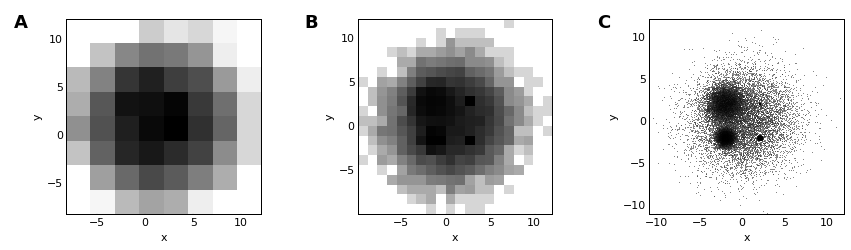

In [12]:
try:
    from skimage.exposure import equalize_hist
    eq_hist = lambda d,m: equalize_hist(1000*d,nbins=100000,mask=m)
except ImportError:
    eq_hist = lambda d,m: d
    print("scikit-image not installed; skipping histogram equalization")
    
hv.Layout([heatmap(dist,bins,transform=eq_hist) for bins in [8,20,200]])

Plot **C** now reveals the full structure that we know was in this dataset, i.e. five Gaussians with different spreads, with no arbitrary parameter choices. (Well, there is a "number of bins" parameter for building the histogram for equalizing, but for integer data like this even that parameter can be eliminated entirely.)  The differences in counts between pixels are now very clearly visible, across the full (and very wide) range of counts in the original data.

Of course, we've lost the actual counts themselves, and so we can no longer tell just how many datapoints are in the "very narrow spread" pixel in this case.  So plot **C** is accurately conveying the structure, but additional information would need to be provided to show the actual counts, by adding a color key mapping from the visible gray values into the actual counts and/or by providing hovering value information.

At this point, one could also consider explicitly highlighting hotspots so that they cannot be overlooked.  In plots B and C above, the two highest-density pixels are mapped to the two darkest pixel colors, which can reveal problems with your monitor settings if they were adjusted to make dark text appear blacker.  Thus on those monitors, the highest values may not be  clearly distinguishable from each other or from nearby grey values, which is a possible downside to fully utilizing the dynamic range available.  But once the data is reliably and automatically mapped into a repeatable, reliable, fully utilized range for display, making explicit adjustments (e.g. based on wanting to make hotspots particularly clear) can be done in a principled way that doesn't depend on the actual data distribution (e.g. by just making the top few pixel values into a different color, or by stretching out those portions of the color map to show the extremes more safely across different monitors). Before getting into such specialized manipulations, there's a big pitfall to avoid first:

### 6. Nonuniform colormapping

Let's say you've managed avoid pitfalls 1-5 somehow.  However, there is one more problem waiting to catch you at the last stage, ruining all of your work eliminating the other issues: using a perceptually non-uniform colormap.  A heatmap requires a colormap before it can be visualized, i.e., a lookup table from a data value (typically a normalized magnitude in the range 0 to 1) to a pixel color.  The goal of a scientific visualization is to reveal the underlying properties of the data to your visual system, and to do so it is necessary to choose colors for each pixel that lead the viewer to perceive that data faithfully.  Unfortunately, most of the colormaps in common use in plotting programs are highly *non*uniform.  

For instance, in "jet" (the default colormap for matlab and matplotlib until 2015), a large range of data values will all appear in shades of green that are perceptually indistinguishable, and similarly for the yellow regions of their "hot" colormaps:

![hot_jet](https://github.com/bokeh/colorcet/raw/master/docs/images/hot_jet.png)

In this image, a good colormap would have "teeth" equally visible at all data values, as for the perceptually uniform equivalents from the [colorcet](https://github.com/bokeh/colorcet) package:

![fire_rainbow](https://github.com/bokeh/colorcet/raw/master/docs/images/fire_rainbow.png)

We can easily see these effects if we look at our example dataset after histogram equalization, where all the different data levels are known to be distributed evenly in the array of normalized magnitudes:

In [ ]:
hv.Layout([heatmap(dist,200,transform=eq_hist,label=cmap)(style=dict(cmap=cmap)) for cmap in ["hot","fire"]]).cols(2)

Comparing **A** to **B** it should be clear that the "fire" colormap is revealing much more of the data, accurately rendering the density differences between each of the different blobs.  The unsuitable "hot" colormap is mapping all of the high density regions to perceptually indistinguishable shades of bright yellow/white, giving an "oversaturated" appearance even though we know the underlying heatmap array is *not* oversaturated (by construction).  Luckily it is easy to avoid this problem; just use one of the 50 perceptually uniform colormaps available in the [colorcet](https://github.com/bokeh/colorcet) package, one of the four shipped with matplotlib [(viridis, plasma, inferno, or magma)](https://bids.github.io/colormap), or the Parula colormap shipped with Matlab.


## Summary

Starting with plots of specific datapoints, we showed how typical visualization techniques will systematically misrepresent the distribution of those points.  Here's an example of each of those six problems, all for the same distribution:

:Layout
   .Points.A_1_full_stop_Overplotting               :Points   [x,y]
   .Points.A_2_full_stop_Oversaturation             :Points   [x,y]
   .Points.A_3_full_stop_Undersampling              :Points   [x,y]
   .Points.A_4_full_stop_Undersaturation            :Points   [x,y]
   .Image.A_5_full_stop_Underutilized_dynamic_range :Image   [x,y]   (z)
   .Image.A_6_full_stop_Nonuniform_colormapping     :Image   [x,y]   (z)
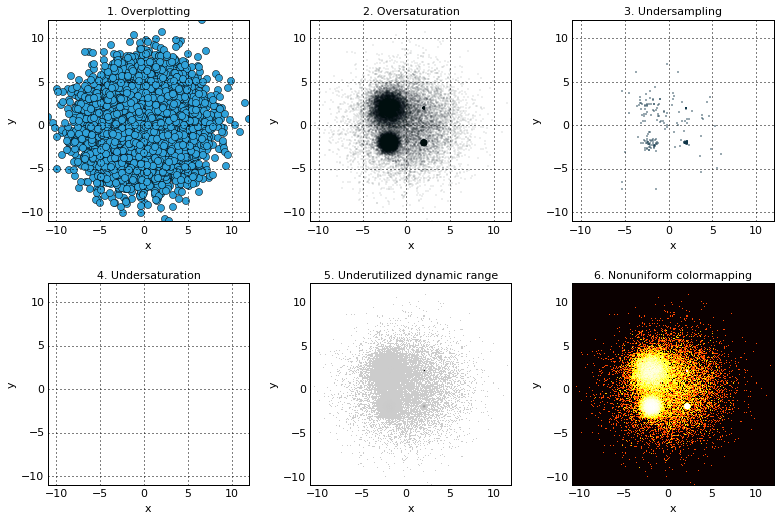

In [15]:
%%opts Layout [sublabel_format="" tight=True] Points {-axiswise}
(hv.Points(dist,label="1. Overplotting") + 
 hv.Points(dist,label="2. Oversaturation")(style=dict(s=0.1,alpha=0.5)) + 
 hv.Points((dist[0][::200],dist[1][::200]),label="3. Undersampling")(style=dict(s=2,alpha=0.5)) + 
 hv.Points(dist,label="4. Undersaturation")(style=dict(s=0.01,alpha=0.05)) + 
 heatmap(dist,200,offset=0.2,label="5. Underutilized dynamic range") +
 heatmap(dist,200,transform=eq_hist,label="6. Nonuniform colormapping")(style=dict(cmap="hot"))).cols(3)

Here we could avoid each of these problems by hand, using trial and error based on our knowledge about the underlying dataset, since we created it.  But for big data in general, these issues are major problems, because you don't know what the data *should* look like. Thus:

#### For big data, you don't know when the viz is lying

I.e., visualization is supposed to help you explore and understand your data, but if your visualizations are systematically misrepresenting your data because of **overplotting**, **oversaturation**, **undersampling**, **undersaturation**, **underutilized range**, and **nonuniform colormapping**, then you won't be able to discover the real qualities of your data and will be unable to make the right decisions.

Luckily, using the systematic approach outlined in this discussion, you can avoid *all* of these pitfalls, allowing you to render your data faithfully without requiring *any* "magic parameters" that depend on your dataset:

In [ ]:
heatmap(dist,200,transform=eq_hist)(style=dict(cmap="fire"))

The steps above show how to implement this approach by hand, but it can be awkward and relatively slow to do so.  Luckily there is a new library available to automate and optimize these steps:

### Datashader

The [datashader](https://github.com/bokeh/datashader) library has been designed to overcome the above pitfalls, by automatically calculating appropriate parameters based on the data itself using the techniques outlined above.  Dataset supports interactive visualizations of even truly large datasets with millions or billions of data points, making it simple to reveal their structure without trial and error. Using datashader together with [colorcet](https://github.com/bokeh/colorcet), it should now be simple and quick to render even the largest datasets faithfully.